notebook generates rebinned spectra and physical quantities, given specified integration time 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy import optimize
from scipy.optimize import curve_fit

import sys
sys.path.append("../")
from create_arrays import siiv

In [2]:
# import arrays
tube = readsav('/Users/WilliamHenryAshfieldIV/dat/ebtel_l85_h150_30min_subI.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/dat/nei_files/ebtel_30min_subI_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [3]:
t_n = tube.tarr.shape[0] - 1 # len of tube in time (in steps of 0.1s)
line = 1402.77
ll = np.arange(line-10,line+10,0.01)

../create_arrays.py:68: RuntimeWarning: invalid value encountered in true_divide
  temp_fac = f_nei/f_eqi
../create_arrays.py:128: RuntimeWarning: invalid value encountered in true_divide
  factor = nei/eqi
../create_arrays.py:182: RuntimeWarning: invalid value encountered in sqrt
  meas_error = np.sqrt(tot_emissNEI) # error measured


(1402, 1404)

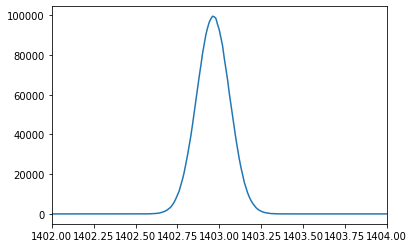

In [4]:
k = 155
test = siiv(tube,frac,log10T,log10G,time=k)
plt.plot(test.wav,test.spec)
plt.xlim(1402,1404)

In [5]:
ll = test.wav

In [6]:
SPEC = np.zeros((t_n,len(test.spec)))
ERROR = np.zeros((t_n,len(test.error)))

for i in range(0,t_n):

    arrs = siiv(tube,frac,log10T,log10G,time=i)

    SPEC[i,:] = arrs.spec 
    ERROR[i,:] = arrs.error

KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,SPEC[120,:])
plt.plot(ll,SPEC[150,:])
plt.plot(ll,SPEC[155,:])
plt.plot(ll,SPEC[165,:])
plt.xlim(1401,1405)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

In [9]:
SPEC.shape

(800, 2000)

# Rebin our synthetic spectrum:

In [10]:
dt = 0.2
inegration = 5 # seconds (iris)
reshape = int(inegration/dt)
reshape

25

In [11]:
SPECII = SPEC.reshape(-1,reshape,2000)
SPECII.shape

ERRORII = ERROR.reshape(-1,reshape,2000)
ERRORII.shape

(32, 25, 2000)

In [12]:
spec = np.mean(SPECII,axis=1)
error = np.mean(ERRORII,axis=1)

In [13]:
nt = error.shape[0] # number of time elements after rebin.
print(nt)

32


Text(0.5, 0, 'wavelength [$\\AA$]')

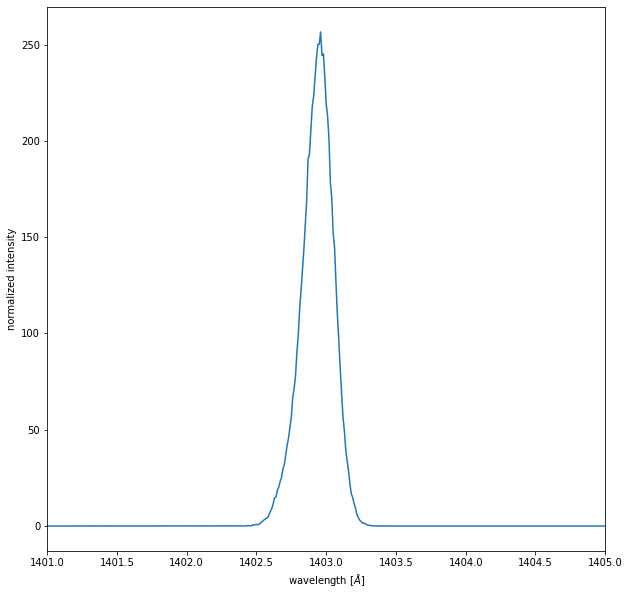

In [14]:
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,spec[5,:])
plt.xlim(1401,1405)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

Save new specturm array to txt file:

In [15]:
# np.savetxt('../dat/rebins/f4_t10_h20_tri.txt', spec, fmt='%d')
# np.savetxt('../dat/rebins/f4_t10_h20_tri_err.txt', error, fmt='%d')

# Animate our rebinned spectrum:

In [16]:
from matplotlib import animation, rc
from IPython.display import HTML

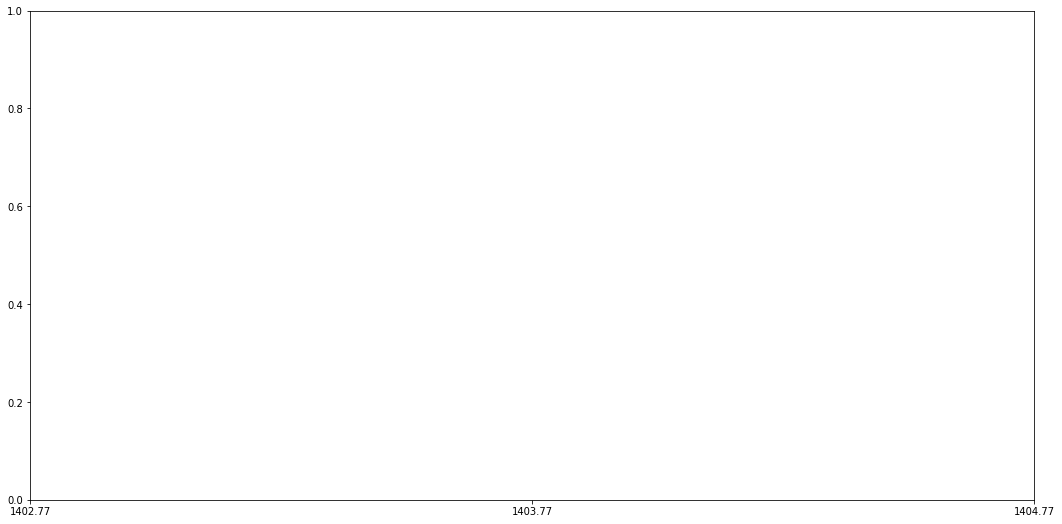

In [17]:
fig, ax = plt.subplots(figsize=(18,9))
ax.set_xlim(1402.77,1404)
ax.set_xticks(np.arange(1402.77, 1405, 1))

In [18]:
# data placeholders
wav,specs = np.zeros(0),np.zeros(0)#,np.zeros(0),np.zeros(0),np.zeros(0),np.zeros(0),np.zeros(0)

# plot placeholder/object
plot_spec, = ax.plot(wav,specs)

In [19]:
def update(i):

    global wav
    global specs
    
    wav = ll
    specs = spec[i,:]
    
    plot_spec.set_data(wav,specs)
   
    plot_spec.axes.set_ylim(0,np.max(specs)+0.05*np.max(specs))
    time = np.around(i*5, decimals=1)
    plot_spec.axes.set_ylim(0,np.max(specs)+0.05*np.max(specs))
    plot_spec.axes.set_title('time = '+str(time)+'s')
    plot_spec.axes.ticklabel_format(style='sci',axis='y',useMathText=False,scilimits=(0,2))
    
    return plot_spec

In [20]:
simulation = animation.FuncAnimation(fig, update, blit=False, frames= nt, interval=250, repeat=False)

In [21]:
HTML(simulation.to_html5_video())

In [22]:
#simulation.save(filename='sml.mp4',fps=2,dpi=300)

In [23]:
spec.shape

(32, 2000)

# Time series of synthetic spectrum:

In [24]:
time = np.arange(0,spec.shape[0]*5,5)
nt = len(time)-1

In [25]:
from fit2gauss import fit2gauss
v_r = np.zeros(nt)
v_b = np.zeros(nt)
w_r = np.zeros(nt)
w_b = np.zeros(nt)

amp = np.zeros(nt)

for i in range(0,nt):
    
    t_i = time[i]
    
    dat = spec[i,:]
    err = error[i,:]
        
    res = fit2gauss(ll,dat,err,chi_thr=100.)
    a2g = res["a2g"] # extract fit parameters
    a1g = res["a1g"]

    #calculate Doppler velocities and wavelengths
    line = 1402.77
    c = 300.
    freq = c/line*1e3

    amp[i] = a1g[0]

    if a2g[1] < a2g[4]:
        v_b[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_r[i] = (a2g[4]-line)/line*3e5
        #w_b[i] = a2g[2]*freq
        #w_r[i] = a2g[5]*freq

    else:
        v_r[i] = (a2g[1]-line)/line*3e5 # in km/s
        v_b[i] = (a2g[4]-line)/line*3e5
        #w_r[i] = a2g[2]*freq
        #w_b[i] = a2g[5]*freq

(0, 60)

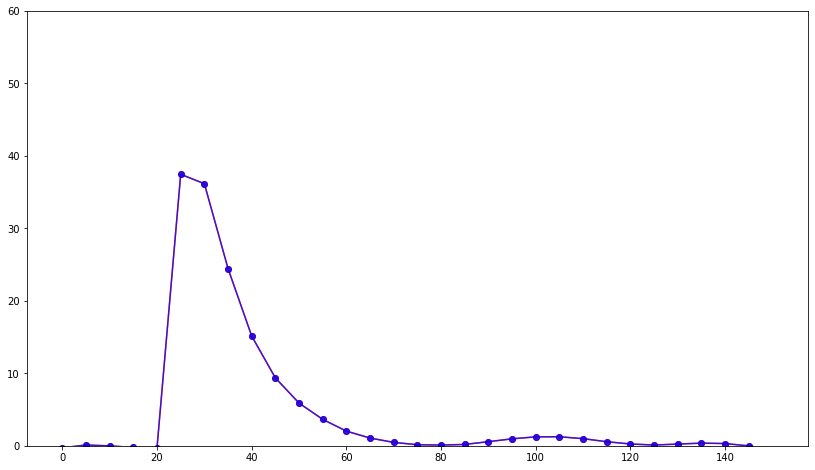

In [26]:
plt.figure(figsize=(14,8))
plt.plot(time[0:-1],v_r,'r',alpha=0.75,marker='o')
plt.plot(time[0:-1],v_b,'b',alpha=0.75,marker='o')
plt.ylim(0,60)

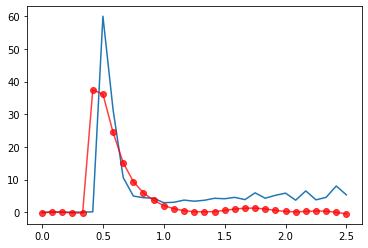

In [27]:
plt.plot(time[0:-1]/60,amp/np.max(amp)*60)
plt.plot(time[0:-1]/60,v_r,'r',alpha=0.75,marker='o')

In [28]:
spec_fit,error_fit = spec[6,:],error[6,:]
res = fit2gauss(ll,spec_fit,error_fit,chi_thr=50.,verbose=True)

est params =  [9568.521523718246, 1403.2757798140074, 0.1, 111024.29127982001, 1402.9101187104475, 0.1]
single peak found
only one peak still
new init params =  [9568.521523718246, 1403.2757798140074, 0.1, 111024.29127982001, 1402.9101187104475, 0.1]
a2g = [-1.82980285e-01  1.40343805e+03  7.59510910e-03  1.20595065e+05
  1.40293913e+03  9.88279812e-02]
a1g[0] = 120595.2643767031
chi2g =  0.003781943126167707
a2g =  [1.20595264e+05 1.40293910e+03 9.88270599e-02 0.00000000e+00
 1.40293910e+03 9.88270599e-02]
chi1g =  0.004263658670294518
chi2g =  -1.0


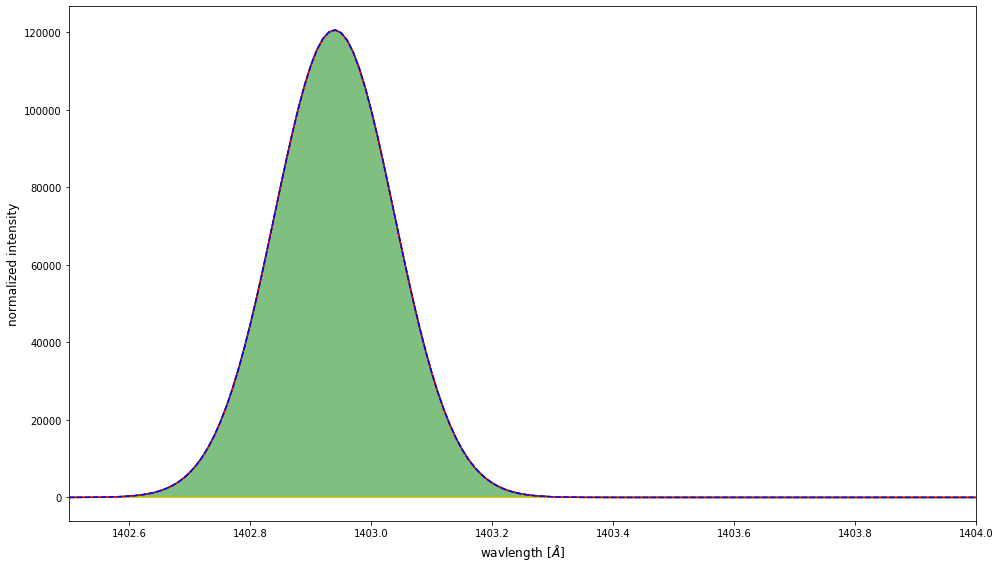

In [29]:
from matplotlib import gridspec
# extract arrays
y2a = res["y2a"]
y2b = res["y2b"]
y1g = res["y1g"]

#plot 
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

# spectra
ax1.plot(ll, spec_fit)

# peak 1
ax1.plot(ll, y2a, "g")
ax1.fill_between(ll, y2a.min(), y2a, facecolor="green", alpha=0.5)
  
# peak 2
ax1.plot(ll, y2b, "y")
ax1.fill_between(ll, y2b.min(), y2b, facecolor="yellow", alpha=0.5) 

#both
ax1.plot(ll,y2a+y2b, "r")

# single fit
ax1.plot(ll,y1g,'b--')
    
plt.xlim(1402.5,1404)
#plt.ylim(0,3000)
ax1.set_xlabel("wavlength [$\AA$]",  fontsize=12)
ax1.set_ylabel("normalized intensity",  fontsize=12)
fig.tight_layout()

# Fit:

In [30]:
def u0_fit(t, *a):
    return a[0]/(1+t/a[1])

In [31]:
imax = np.argmax(v_r) 

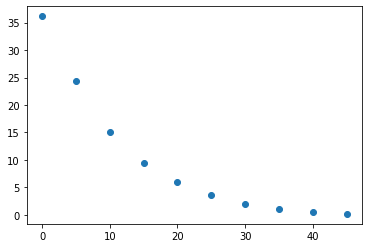

In [39]:
tt = time[imax+1:-16] 
tt = tt-tt[0]
vr = v_r[imax+1:-15]
plt.plot(tt,vr,'o')

In [40]:
a0= [55,15]
popt, pcov = curve_fit(u0_fit, tt, vr,p0=a0)

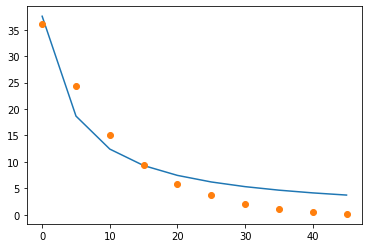

In [41]:
plt.plot(tt,u0_fit(tt,*popt))
plt.plot(tt,vr,'o')

In [42]:
popt[1]

4.938446317034022

In [43]:
H = 0.6*popt[0]*popt[1]

In [44]:
H

111.30320202814696